# Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('datasets/dataset1.csv')
df.head()

,Data,ConsumoEnergia
0,2014-01-01,925.830568
1,2014-02-01,1037.218770
2,2014-03-01,1028.084349
3,2014-04-01,925.841032
4,2014-05-01,993.135727


In [7]:
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)
df.head()

,ConsumoEnergia
Data,
2014-01-01,925.830568
2014-02-01,1037.218770
2014-03-01,1028.084349
2014-04-01,925.841032
2014-05-01,993.135727


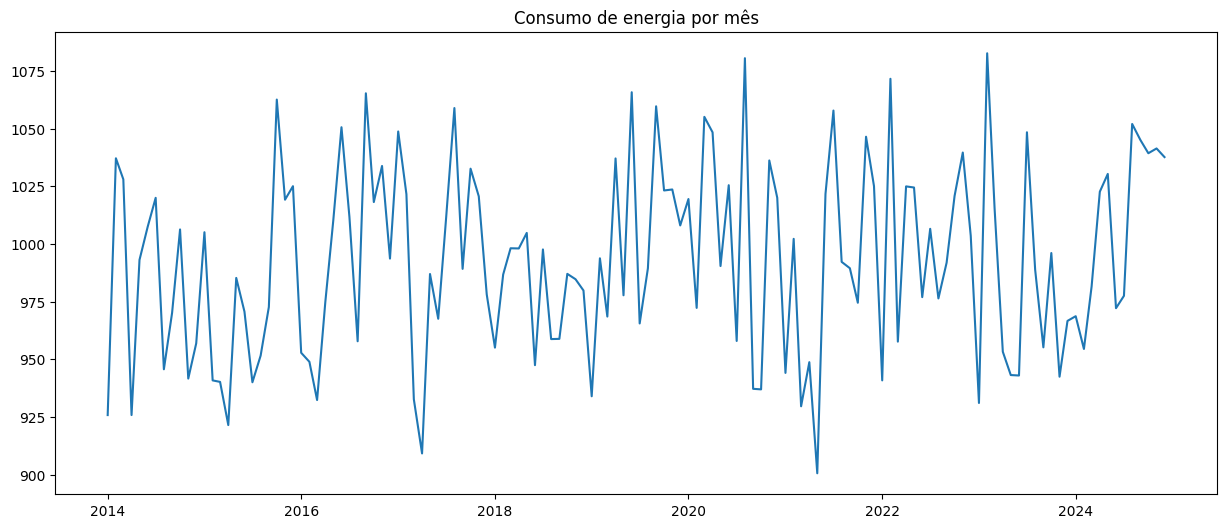

In [8]:
plt.figure(figsize=(15,6))
plt.plot(df['ConsumoEnergia'])
plt.title("Consumo de energia por mês")
plt.show()

# Decomposição da Série Temporal

In [9]:
decomp = seasonal_decompose(df, model='additive')

Text(0.5, 0.98, 'Decomposição da Série Temporal')

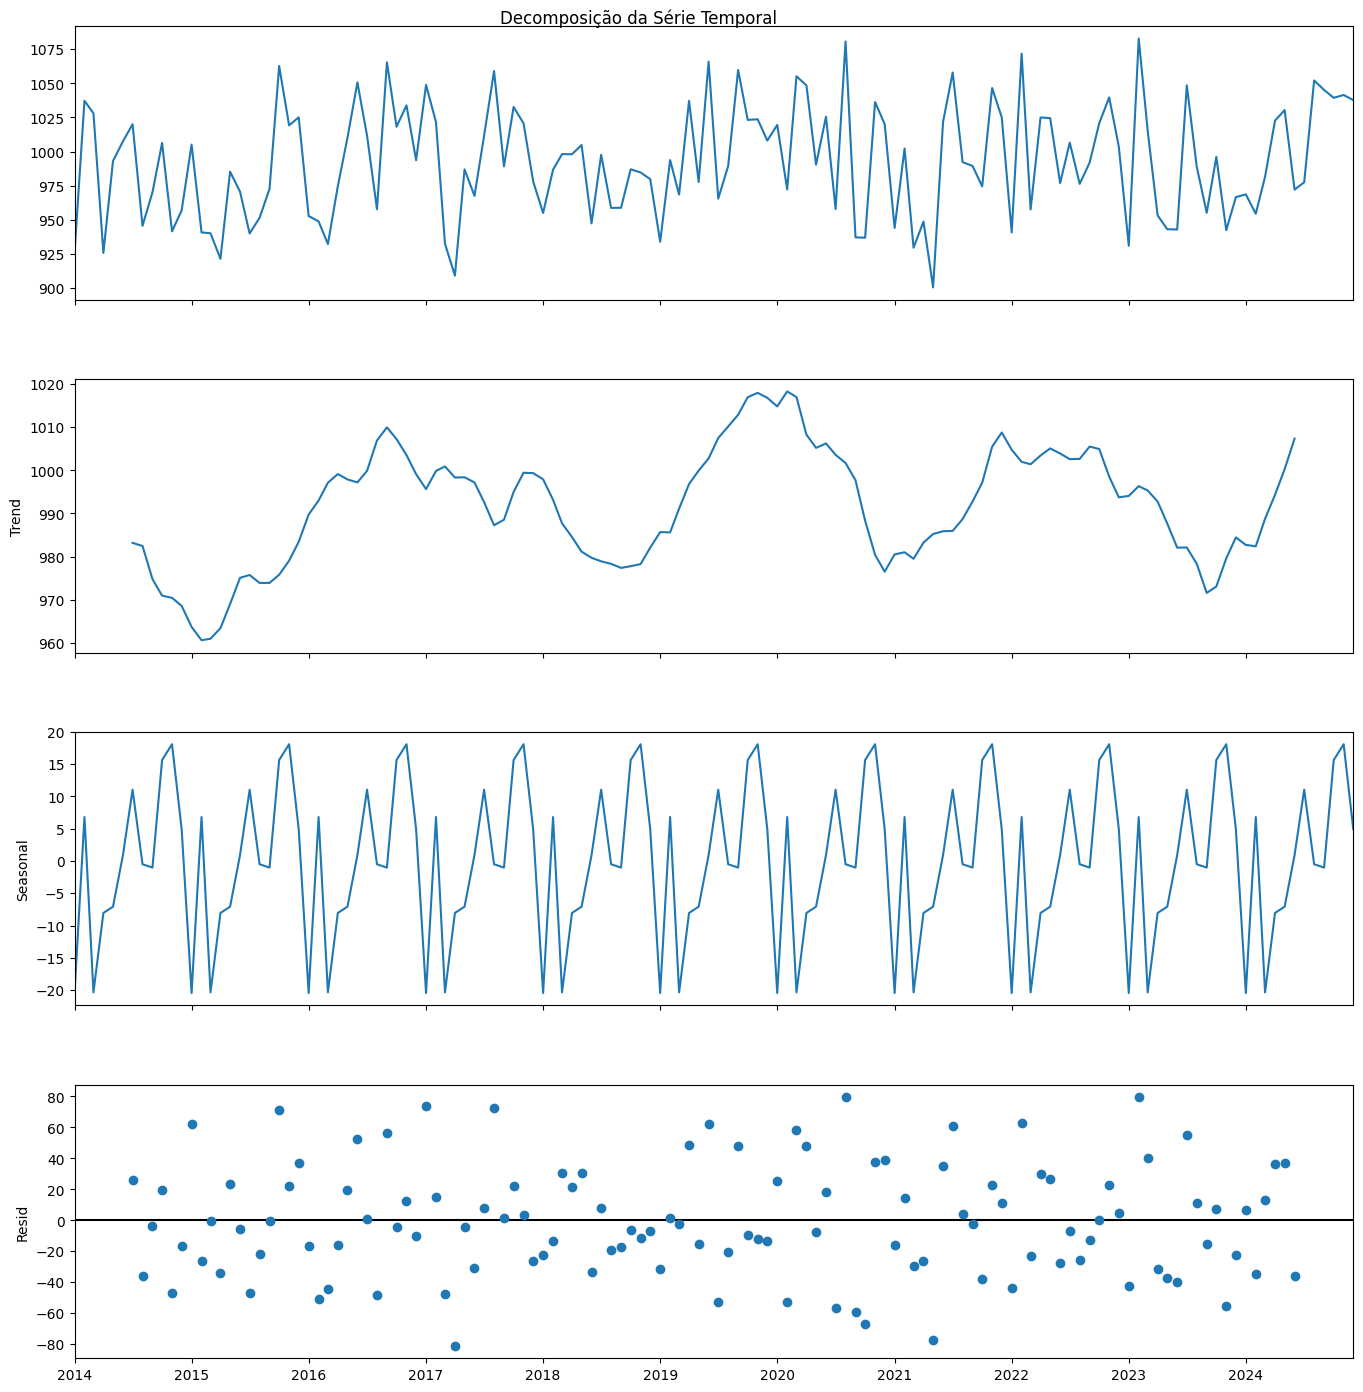

In [10]:
ax = decomp.plot()
ax.set_size_inches(15,15)
plt.suptitle('Decomposição da Série Temporal')

# Plot das Rolling Statistics

Text(0.5, 1.0, 'Série Temporal e Rolling Statistics')

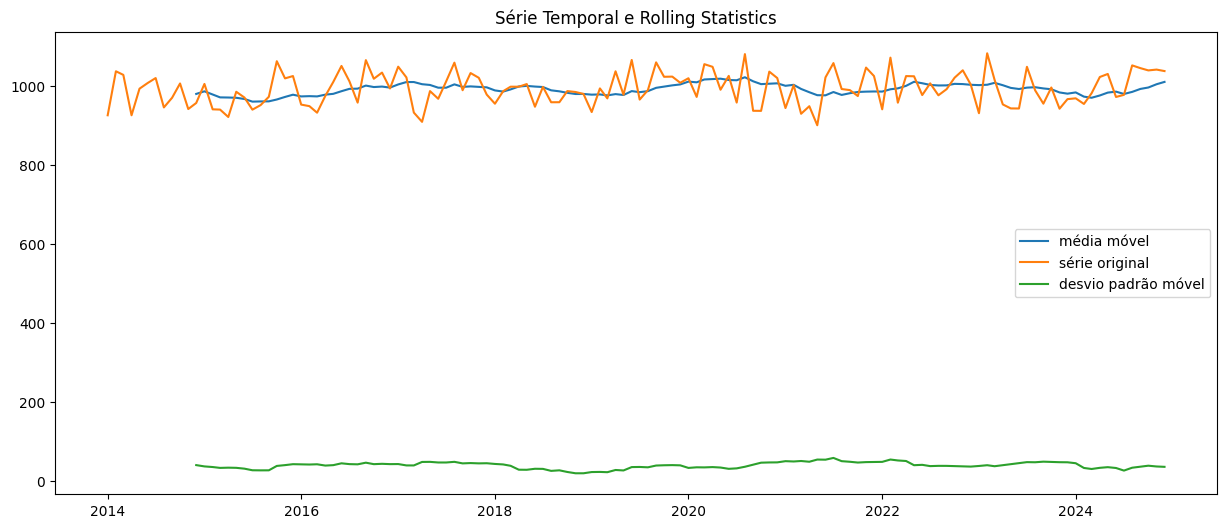

In [11]:
mov_avg = df['ConsumoEnergia'].rolling(window=12).mean()
mov_std = df['ConsumoEnergia'].rolling(window=12).std()

plt.figure(figsize=(15,6))
plt.plot(mov_avg, label = 'média móvel')
plt.plot(df['ConsumoEnergia'], label = 'série original')
plt.plot(mov_std, label = 'desvio padrão móvel')
plt.legend()
plt.title('Série Temporal e Rolling Statistics')

A série parece ser estacionária, mas só teremos certeza com um teste estatístico

# AutoCorrelação

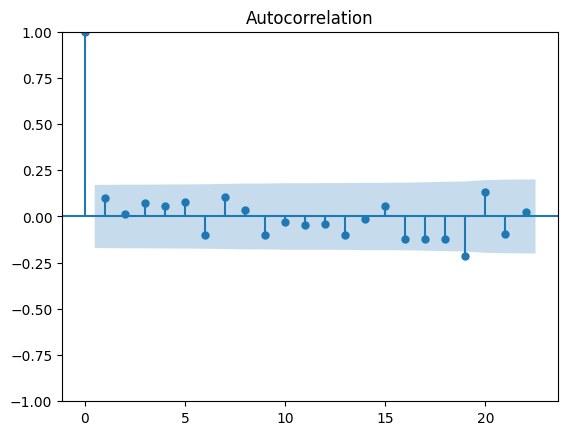

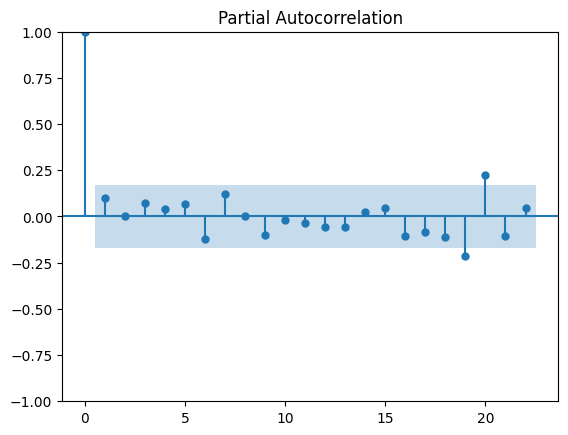

In [14]:
ax1 = plot_acf(df)
ax2 = plot_pacf(df)

# Teste de estacionariedade

In [20]:
def dickey_fuller_test(data:pd.DataFrame, variable:str):

    print('\nResultado do Teste Dickey-Fuller:\n')

    dfteste = adfuller(data[variable], autolag = 'AIC')

    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                            'Valor-p',
                                            'Número de Lags Consideradas',
                                            'Número de Observações Usadas'])

    for key,value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    return dfsaida

In [21]:
dickey_fuller_test(df, 'ConsumoEnergia')


Resultado do Teste Dickey-Fuller:



Estatística do Teste           -1.034322e+01
Valor-p                         2.651794e-18
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    1.310000e+02
Valor Crítico (1%)             -3.481282e+00
Valor Crítico (5%)             -2.883868e+00
Valor Crítico (10%)            -2.578677e+00
dtype: float64

Temos evidencia estatística para rejeitar HO. Logo a série é estacionária.

In [27]:
TestADF = pm.arima.ADFTest(alpha=0.05)
TestADF.should_diff(df['ConsumoEnergia'])

(0.01, False)

In [34]:
train_size = int(len(df)*0.8)
df_train = df.iloc[:train_size,:]
df_test = df.iloc[train_size:,:]

# Otimização dos hiperparâmetros usando Auto ARIMA nos dados de treino

In [44]:
auto_model = pm.auto_arima(df_train['ConsumoEnergia'],
                                seasonal = False, 
                                m = 0, 
                                start_p = 0, 
                                start_d = 0,
                                start_q = 0,
                                max_p = 3, 
                                max_d = 3,
                                max_q = 3, 
                                information_criterion = 'aic',
                                trace = True, 
                                stepwise = False,
                                error_action = 'ignore',
                                n_jobs=-1)

/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/pytho

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1748.963, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1095.501, Time=0.23 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/pytho

 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1520.562, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1097.161, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1099.122, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1097.141, Time=0.46 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1099.052, Time=0.42 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.787 seconds


# Avaliação do Modelo

In [46]:
train_preds = auto_model.predict_in_sample()

In [47]:
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -544.751
Date:                ter, 11 mar 2025   AIC                           1095.501
Time:                        22:43:46   BIC                           1103.463
Sample:                    01-01-2014   HQIC                          1098.728
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    1.1e-05   9.06e+04      0.000       1.000       1.000
ma.L1         -0.9674      0.034    -28.180      0.000      -1.035      -0.900
sigma2      1723.0101    289.644      5.949      0.0

In [48]:
# Calcula o MAE e o MSE entre as previsões históricas e os valores reais
mae_train = mean_absolute_error(df_train['ConsumoEnergia'], train_preds)
mse_train = mean_squared_error(df_train['ConsumoEnergia'], train_preds)

print(f'Mean Absolute Error (MAE) com dados de treino: {mae_train}')
print(f'Mean Squared Error (MSE) com dados de treino: {mse_train}')

Mean Absolute Error (MAE) com dados de treino: 43.12557176780755
Mean Squared Error (MSE) com dados de treino: 9963.823311094582


In [50]:
test_preds = auto_model.predict(n_periods=len(df_test))

In [51]:
# Calcula o MAE e o MSE entre as previsões históricas e os valores reais
mae_test = mean_absolute_error(df_test['ConsumoEnergia'], test_preds)
mse_test = mean_squared_error(df_test['ConsumoEnergia'], test_preds)

print(f'Mean Absolute Error (MAE) com dados de treino: {mae_test}')
print(f'Mean Squared Error (MSE) com dados de treino: {mse_test}')

Mean Absolute Error (MAE) com dados de treino: 37.12328308751206
Mean Squared Error (MSE) com dados de treino: 1747.2665676333081


Text(0.5, 1.0, 'Gráfico das Previsões em Treino e Teste')

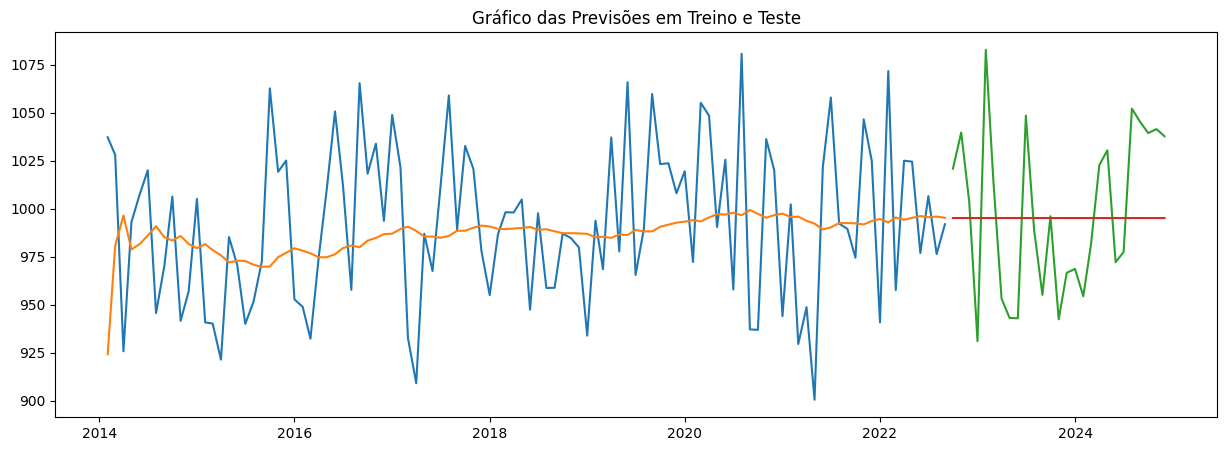

In [62]:
plt.figure(figsize=(15,5))
plt.plot(df_train[1:])
plt.plot(train_preds[1:])
plt.plot(df_test)
plt.plot(test_preds)
plt.title('Gráfico das Previsões em Treino e Teste')

In [69]:
# Reajustando modelo com todos os dados
forecast = auto_model.fit_predict(df, n_periods=12, return_conf_int = True)

Text(0.5, 1.0, 'Gráfico das Previsões em Treino, Teste com Forecast')

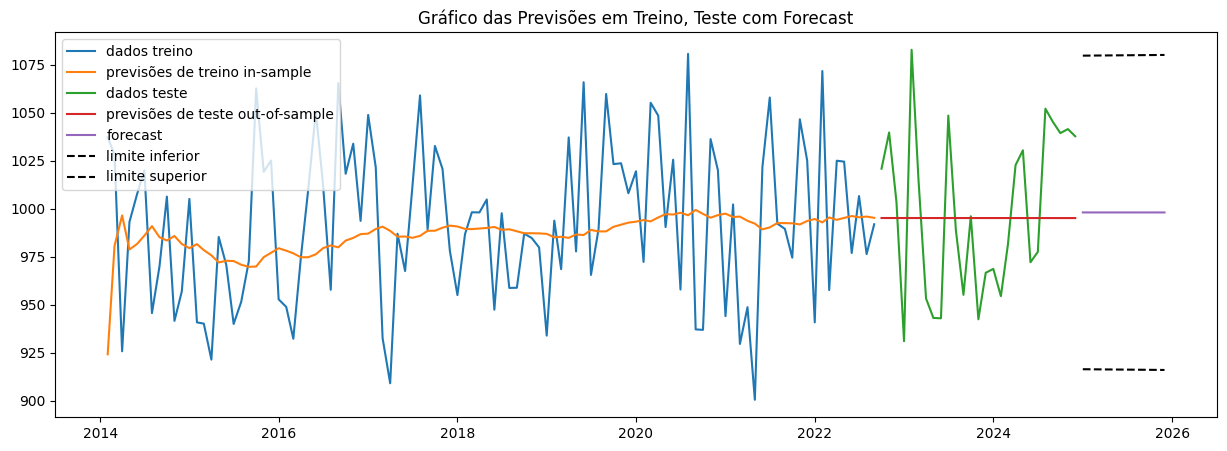

In [104]:
plt.figure(figsize=(15,5))
plt.plot(df_train[1:], label = 'dados treino')
plt.plot(train_preds[1:], label = 'previsões de treino in-sample')
plt.plot(df_test, label = 'dados teste')
plt.plot(test_preds, label = 'previsões de teste out-of-sample')
plt.plot(forecast[0], label = 'forecast')
plt.plot(forecast[0].index, forecast[1][:,0], label = 'limite inferior', ls='--', color = 'black')
plt.plot(forecast[0].index, forecast[1][:,1], label = 'limite superior', ls = '--', color = 'black')
plt.legend()
plt.title('Gráfico das Previsões em Treino, Teste com Forecast')

# Trabalhando com a variável Exógena

In [108]:
df2 = pd.read_csv('datasets/dataset2.csv', parse_dates=['Data'])
df2.set_index('Data', inplace=True)
df2.head()

,ConsumoEnergia,Temperatura
Data,,
2014-01-01,974.560802,29.238040
2014-02-01,1037.744229,24.387199
2014-03-01,1053.282839,24.914687
2014-04-01,1024.963318,14.073665
2014-05-01,1009.423152,21.545080


In [109]:
exog = df2[['Temperatura']]
exog.head()

,Temperatura
Data,
2014-01-01,29.238040
2014-02-01,24.387199
2014-03-01,24.914687
2014-04-01,14.073665
2014-05-01,21.545080


In [110]:
# Dividindo os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df2) * 0.8)
df2_train, df2_test = df2.iloc[:train_size], df2.iloc[train_size:]
exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

# Treinamento com Auto ARIMA e Variável Exógena

In [117]:
df2_train

,ConsumoEnergia,Temperatura
Data,,
2014-01-01,974.560802,29.238040
2014-02-01,1037.744229,24.387199
2014-03-01,1053.282839,24.914687
2014-04-01,1024.963318,14.073665
2014-05-01,1009.423152,21.545080
...,...,...
2022-05-01,1005.282630,16.661652
2022-06-01,1004.193328,14.988498
2022-07-01,967.754607,25.447831


In [112]:
auto_model_exog = pm.auto_arima(df2_train['ConsumoEnergia'], 
                                exogenous = exog_train,
                                seasonal = True, 
                                m = 12, 
                                start_p = 0, 
                                start_d = 0, 
                                start_q = 0,
                                max_p = 3, 
                                max_d = 3, 
                                max_q = 3, 
                                start_P = 0, 
                                start_D = 0, 
                                start_Q = 0,
                                max_P = 3, 
                                max_D = 3,
                                max_Q = 3,
                                max_order = 5,
                                information_criterion = 'aic',
                                trace = True, 
                                stepwise = False,
                                error_action = 'ignore',
                                n_jobs=-1)

/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1118.607, Time=0.19 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1122.508, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1120.503, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1118.156, Time=0.44 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/pytho

 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1120.609, Time=0.43 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1119.782, Time=0.93 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1120.156, Time=0.48 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1117.736, Time=1.52 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1120.145, Time=1.25 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1122.486, Time=0.09 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1121.957, Time=1.37 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1120.566, Time=0.40 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1121.782, Time=1.32 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1120.055, Time=0.40 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1124.455, Time=0.57 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1122.573, Time=0.47 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=1121.727, Time=1.12 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=1123.853, Time=2.57 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1122.054, Time=1.02 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=1121.990, Time=2.91 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=1122.131, Time=3.62 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=3.38 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1123.402, Time=0.31 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=1125.998, Time=1.95 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=1123.727, Time=2.42 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=1121.691, Time=0.51 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/pytho

 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=1568.901, Time=2.41 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=1125.331, Time=0.87 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=1120.781, Time=0.95 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=1123.699, Time=1.13 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=1123.717, Time=3.56 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=1125.371, Time=0.39 sec
 ARIMA(0,0,2)(0,0,3)[12] intercept   : AIC=1122.577, Time=2.32 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=1123.677, Time=0.78 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=1122.780, Time=2.34 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=1122.732, Time=1.09 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1122.493, Time=0.13 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.81 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=1130.364, Time=2.47 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1120.718, Time=0.29 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=1123.994, Time=2.58 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(3,0,1)[12] intercept   : AIC=1124.061, Time=4.92 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1123.443, Time=0.52 sec
 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=1125.690, Time=1.39 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1120.103, Time=0.97 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1122.650, Time=0.95 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1122.397, Time=0.93 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=inf, Time=2.52 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=1123.977, Time=1.62 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1124.503, Time=0.11 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,3)[12] intercept   : AIC=1121.746, Time=3.40 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1122.605, Time=0.45 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(3,0,0)[12] intercept   : AIC=1205.430, Time=6.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1123.938, Time=2.86 sec
 ARIMA(1,0,0)(1,0,3)[12] intercept   : AIC=1124.123, Time=3.07 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1128.977, Time=3.25 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.02 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=1122.141, Time=1.98 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=1124.530, Time=1.58 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1125.452, Time=0.30 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=1124.224, Time=2.33 sec
 ARIMA(1,0,1)(0,0,3)[12] intercept   : AIC=1123.779, Time=2.95 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=1124.011, Time=4.93 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=1123.731, Time=0.99 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=1124.474, Time=2.80 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1130.106, Time=3.51 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=1138.637, Time=6.25 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1130.040, Time=1.25 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=1122.853, Time=1.73 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1123.329, Time=0.26 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=1127.337, Time=0.75 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1121.767, Time=0.31 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=1126.099, Time=1.89 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=1125.625, Time=1.23 sec
 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=1129.192, Time=1.19 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1124.161, Time=1.20 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=1120.686, Time=1.66 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=1189.632, Time=3.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1123.611, Time=1.38 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1125.336, Time=0.45 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1123.623, Time=0.81 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=1122.600, Time=2.32 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(2,0,0)(0,0,3)[12] intercept   : AIC=1122.468, Time=3.26 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1129.829, Time=0.86 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=1127.986, Time=6.72 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1126.865, Time=0.71 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=1127.775, Time=1.41 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=1125.314, Time=0.15 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=1123.049, Time=2.37 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=1129.010, Time=0.82 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=1146.220, Time=3.75 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=1123.755, Time=0.66 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1146.131, Time=1.54 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1125.347, Time=2.28 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=1127.310, Time=0.57 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=1125.453, Time=1.78 sec


/home/ander/.pyenv/versions/3.10.16/envs/myenv_310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=1125.857, Time=2.12 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=1122.646, Time=2.56 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=1153.334, Time=3.92 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=1314.825, Time=5.76 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=1125.617, Time=1.63 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=1126.535, Time=0.63 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=1131.383, Time=1.43 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.92 sec

Best model:  ARIMA(0,0,0)(2,0,0)[12] intercept
Total fit time: 29.441 seconds


# Avaliação do Modelo com Var. Exógena

In [118]:
train_preds = auto_model_exog.predict_in_sample()

In [119]:
print(auto_model_exog.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  105
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood                -554.868
Date:                  ter, 11 mar 2025   AIC                           1117.736
Time:                          23:26:49   BIC                           1128.351
Sample:                      01-01-2014   HQIC                          1122.037
                           - 09-01-2022                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    997.3386    158.863      6.278      0.000     685.972    1308.705
ar.S.L12       0.2156      0.116      1.852      0.064      -0.013       0.444
ar.S.L24      -0.2157      0.113    

In [120]:
# Calcula o MAE e o MSE entre as previsões históricas e os valores reais
mae_train = mean_absolute_error(df2_train['ConsumoEnergia'], train_preds)
mse_train = mean_squared_error(df2_train['ConsumoEnergia'], train_preds)

print(f'Mean Absolute Error (MAE) com dados de treino: {mae_train}')
print(f'Mean Squared Error (MSE) com dados de treino: {mse_train}')

Mean Absolute Error (MAE) com dados de treino: 37.32794799829062
Mean Squared Error (MSE) com dados de treino: 2286.139259068603


In [121]:
test_preds = auto_model_exog.predict(n_periods=len(df2_test))

In [122]:
# Calcula o MAE e o MSE entre as previsões históricas e os valores reais
mae_test = mean_absolute_error(df2_test['ConsumoEnergia'], test_preds)
mse_test = mean_squared_error(df2_test['ConsumoEnergia'], test_preds)

print(f'Mean Absolute Error (MAE) com dados de treino: {mae_test}')
print(f'Mean Squared Error (MSE) com dados de treino: {mse_test}')

Mean Absolute Error (MAE) com dados de treino: 33.0558986220584
Mean Squared Error (MSE) com dados de treino: 1579.1933212425017


Text(0.5, 1.0, 'Gráfico das Previsões em Treino e Teste')

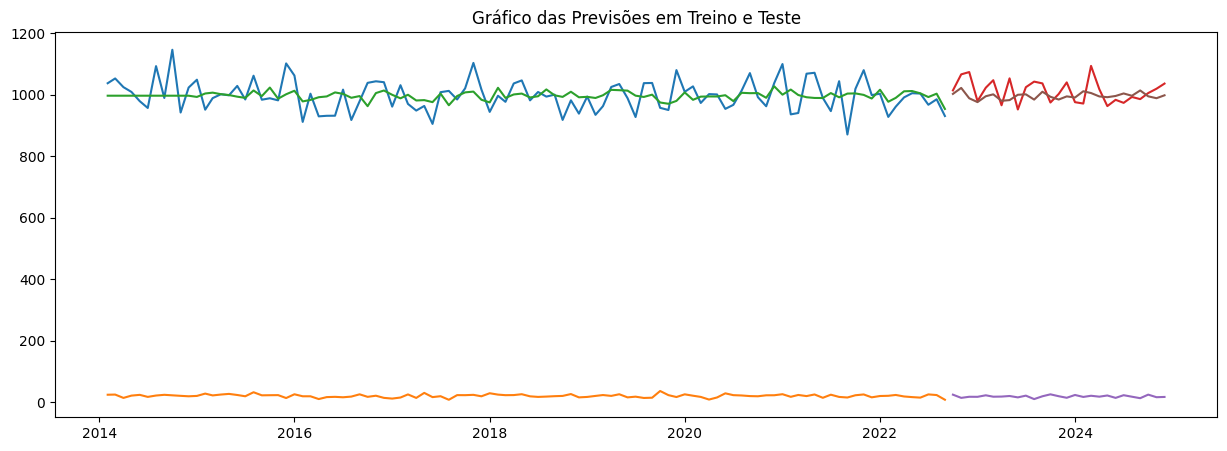

In [123]:
plt.figure(figsize=(15,5))
plt.plot(df2_train[1:])
plt.plot(train_preds[1:])
plt.plot(df2_test)
plt.plot(test_preds)
plt.title('Gráfico das Previsões em Treino e Teste')

In [127]:
# Reajustando modelo com todos os dados
forecast = auto_model_exog.fit_predict(df2['ConsumoEnergia'], n_periods=12, return_conf_int = True)

In [131]:
df2_train

,ConsumoEnergia,Temperatura
Data,,
2014-01-01,974.560802,29.238040
2014-02-01,1037.744229,24.387199
2014-03-01,1053.282839,24.914687
2014-04-01,1024.963318,14.073665
2014-05-01,1009.423152,21.545080
...,...,...
2022-05-01,1005.282630,16.661652
2022-06-01,1004.193328,14.988498
2022-07-01,967.754607,25.447831


Text(0.5, 1.0, 'Gráfico das Previsões em Treino, Teste com Forecast')

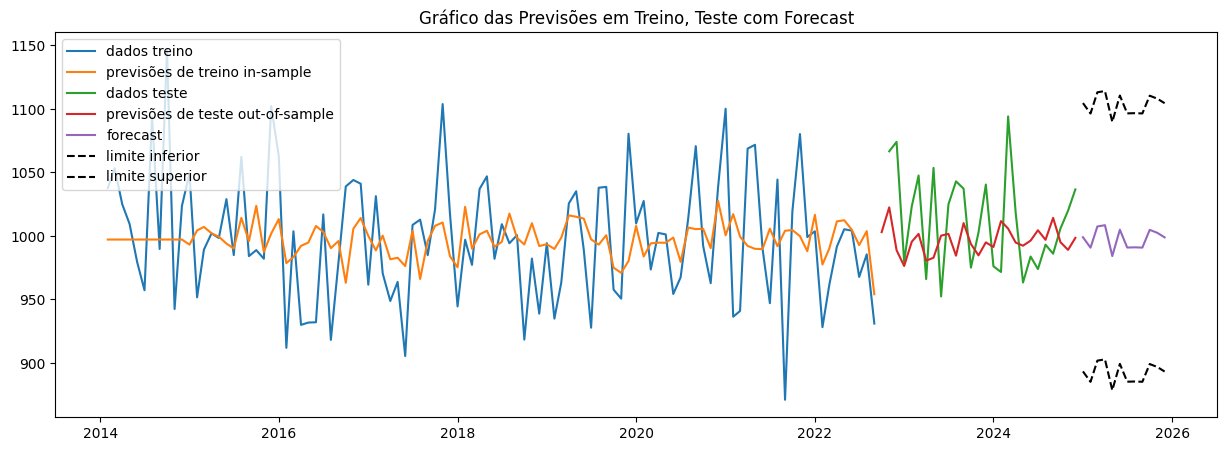

In [136]:
plt.figure(figsize=(15,5))
plt.plot(df2_train.iloc[1:,0], label = 'dados treino')
plt.plot(train_preds[1:], label = 'previsões de treino in-sample')
plt.plot(df2_test.iloc[1:,0], label = 'dados teste')
plt.plot(test_preds, label = 'previsões de teste out-of-sample')
plt.plot(forecast[0], label = 'forecast')
plt.plot(forecast[0].index, forecast[1][:,0], label = 'limite inferior', ls='--', color = 'black')
plt.plot(forecast[0].index, forecast[1][:,1], label = 'limite superior', ls = '--', color = 'black')
plt.legend()
plt.title('Gráfico das Previsões em Treino, Teste com Forecast')

# Conclusão